# Comparing regression analysis with:
- a neural network
- a gaussian process regressor

We want to predict the inherent playing value of a rugby player, based on his skills !
The overall value is measured by CSR (Compound Skills Rating).
The skills are physical and technical attributes.

We aim at comparing two algorithms : a sequential neural network, and a Gaussian Process regressor.

### Import librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import gpytorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import timeit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### NB : works better and faster with a GPU...

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# NB this line would set a global CUDA context, but the DataLoader uses a CPU generator for shuffling : this creates an error !
# torch.set_default_device(device) : 

print(f"Using {device}")
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

torch.set_default_dtype(torch.float32)

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load data

In [4]:
filename = './data/df_tm.csv'
data = pd.read_csv(filename, index_col=0)

In [5]:
data.drop(columns=['energy'], inplace=True)  # Remove the 'energy' column as it is not needed for regression analysis
data

,age,stamina,handling,attack,defense,technique,strength,jumping,speed,agility,kicking,form,aggression,discipline,leadership,experience,weight,height,csr
0,34.0,14.0,13.0,12.0,14.0,15.0,14.0,13.0,11.0,12.0,1.0,9.0,3.0,4.0,5.0,8.0,112.0,203.0,141146.0
1,33.0,13.0,12.0,14.0,16.0,6.0,6.0,7.0,13.0,11.0,12.0,8.0,2.0,3.0,8.0,7.0,83.0,191.0,103797.0
2,25.0,12.0,11.0,15.0,15.0,13.0,11.0,8.0,7.0,6.0,3.0,6.0,3.0,4.0,4.0,3.0,99.0,188.0,86828.0
3,33.0,17.0,17.0,15.0,14.0,17.0,17.0,11.0,13.0,8.0,3.0,8.0,2.0,3.0,3.0,7.0,120.0,197.0,225912.0
4,17.0,10.0,11.0,7.0,5.0,10.0,9.0,12.0,8.0,5.0,3.0,8.0,2.0,4.0,8.0,1.0,111.0,200.0,36298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34192,30.0,14.0,18.0,16.0,13.0,18.0,18.0,9.0,9.0,12.0,10.0,9.0,3.0,2.0,6.0,7.0,117.0,182.0,226718.0
34193,30.0,14.0,15.0,16.0,14.0,18.0,17.0,8.0,12.0,11.0,8.0,7.0,3.0,5.0,9.0,3.0,101.0,189.0,198687.0
34194,26.0,15.0,17.0,14.0,13.0,17.0,16.0,9.0,14.0,12.0,8.0,6.0,3.0,3.0,7.0,5.0,95.0,195.0,194528.0
34195,27.0,16.0,14.0,14.0,14.0,17.0,18.0,8.0,12.0,11.0,8.0,9.0,2.0,4.0,9.0,4.0,118.0,186.0,194577.0


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,34197.0,24.897476,6.675492,17.0,20.0,21.0,31.0,83.0
stamina,34197.0,13.442203,3.676856,1.0,12.0,14.0,16.0,21.0
handling,34197.0,12.901102,3.547711,1.0,11.0,14.0,15.0,21.0
attack,34197.0,12.844489,3.506895,1.0,11.0,14.0,15.0,21.0
defense,34197.0,13.434950,3.323040,1.0,12.0,14.0,16.0,21.0
technique,34197.0,11.710296,3.975157,1.0,9.0,12.0,14.0,21.0
strength,34197.0,11.661140,3.979813,1.0,9.0,12.0,14.0,21.0
jumping,34197.0,7.262450,3.790435,1.0,5.0,7.0,10.0,21.0
speed,34197.0,11.537269,3.924281,1.0,9.0,12.0,14.0,21.0
agility,34197.0,9.775887,4.051186,1.0,7.0,10.0,13.0,21.0


In [7]:
# isolate features and target variable
# 'csr' is the target variable we want to predict

X = data.drop(columns=['csr'])
y = data['csr']

In [8]:
# form training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# normalize data for better performance
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# form datasets and dataloaders for PyTorch training
class CSRDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = CSRDataset(X_train_scaled, y_train)
test_dataset = CSRDataset(X_test_scaled, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Regression by Multi Layer Perceptron network

In [11]:
# Form a simple multilayer perceptron model
class CSRNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(CSRNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        ### x has shape (batch_size, input_size)
        x = self.relu(self.fc1(x))  # First layer with ReLU activation
        x = self.relu(self.fc2(x))  # Second layer with ReLU activation
        x = self.fc3(x)              # Output layer (no activation)
        return x

In [12]:
# Early stopping class to prevent overfitting

class EarlyStoppingCallback:
    def __init__(self, patience=1, min_delta=0):
        # how many epochs do we accept with validation loss non decreasing
        self.patience = patience
        # tolerance for non decrease
        self.min_delta = min_delta
        # how many epochs without validation loss decrease
        self.counter = 0
        # minimum validation loss to beat
        self.min_validation_loss = float('inf')
        self.status = False

    def early_stop(self, validation_loss):
        # is the last validation loss better than the current minimum ?
        # status = True means stop training
        if validation_loss < self.min_validation_loss:
            # yes : update minimum value and reset counter
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.status = False
            # no : are we within tolerance ?
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # no : increase counter (losing patience)
            self.counter += 1
            # have we lost patience ?
            if self.counter >= self.patience:
                # yes
                self.status = True
            else:
                # no
                self.status = False

        return self.status, self.counter
    
early_stopping = EarlyStoppingCallback(patience=5, min_delta=1e-3)

In [13]:
learning_rate = 0.001
criterion = nn.MSELoss()  # Mean Squared Error loss for regression

model = CSRNeuralNetwork(input_size=X_train_scaled.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# One Training Step
def train_step(model, train_loader, learning_rate, criterion, optimizer):
    """Perform one training step on the model."""
    
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        epoch_loss += loss.item()
        
    return model, epoch_loss/len(train_loader)

# One Test Step
def test_step(model, test_loader, criterion):
    """Perform one test step on the model."""
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs.squeeze(), y_batch)
            test_loss += loss.item()
    
    return test_loss / len(test_loader)

In [15]:
# Training the model

def train_model(model, train_loader, test_loader, n_epochs, learning_rate, criterion, optimizer, early_stopping=None):
    """Train the model with early stopping."""
    training_losses = []
    validation_losses = []

    for epoch in range(n_epochs):
        # Train step
        model, train_loss = train_step(model, train_loader, learning_rate, criterion, optimizer)
        training_losses.append(train_loss)

        # Test step
        validation_loss = test_step(model, test_loader, criterion)
        validation_losses.append(validation_loss)

        print(f'Epoch [{epoch+1:<6} .../... {n_epochs:<6}], Training Loss: {train_loss:.4e}, Validation Loss: {validation_loss:.4e}')

        # Early stopping check
        if early_stopping:
            stop, counter = early_stopping.early_stop(validation_loss)
            if stop:
                print(f'Early stopping at epoch {epoch+1} with counter {counter}')
                break

    return model, training_losses, validation_losses

In [16]:
n_epochs = 100

trained_model, training_losses, validation_losses = train_model(
    model, train_loader, test_loader, n_epochs, learning_rate, criterion, optimizer, early_stopping
)

Epoch [1      .../... 100   ], Training Loss: 1.8653e+10, Validation Loss: 4.2634e+09
Epoch [2      .../... 100   ], Training Loss: 2.8804e+09, Validation Loss: 1.9224e+09
Epoch [3      .../... 100   ], Training Loss: 1.1428e+09, Validation Loss: 6.5460e+08
Epoch [4      .../... 100   ], Training Loss: 5.1531e+08, Validation Loss: 4.4825e+08
Epoch [5      .../... 100   ], Training Loss: 4.1479e+08, Validation Loss: 3.9366e+08
Epoch [6      .../... 100   ], Training Loss: 3.7421e+08, Validation Loss: 3.6353e+08
Epoch [7      .../... 100   ], Training Loss: 3.4896e+08, Validation Loss: 3.4176e+08
Epoch [8      .../... 100   ], Training Loss: 3.2966e+08, Validation Loss: 3.2432e+08
Epoch [9      .../... 100   ], Training Loss: 3.1299e+08, Validation Loss: 3.1196e+08
Epoch [10     .../... 100   ], Training Loss: 2.9851e+08, Validation Loss: 2.9628e+08
Epoch [11     .../... 100   ], Training Loss: 2.8531e+08, Validation Loss: 2.8241e+08
Epoch [12     .../... 100   ], Training Loss: 2.7334e+

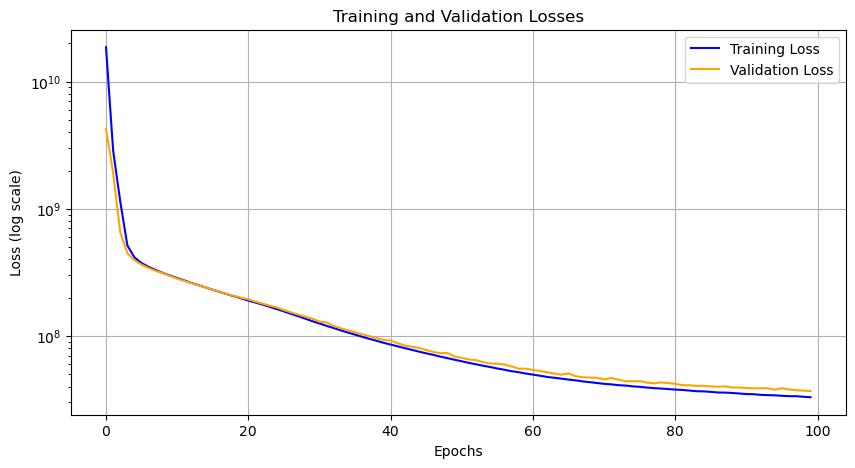

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(training_losses, label='Training Loss', color='blue')
ax.plot(validation_losses, label='Validation Loss', color='orange')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (log scale)')
ax.set_yscale('log')  # Use logarithmic scale for better visibility
ax.set_title('Training and Validation Losses')
ax.legend()
ax.grid(True)
plt.show()

In [18]:
# Run metrics on the prediction by the trained model

def run_metrics(model, test_loader):
    """Run metrics on the predictions made by the model."""
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.squeeze().cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    mse = np.mean((predictions - targets) ** 2)
    mae = np.mean(np.abs(predictions - targets))
    
    print(f'Root Mean Squared Error: {np.sqrt(mse):.0f}')
    print(f'Mean Absolute Error: {mae:.0f}')

In [19]:
run_metrics(trained_model, test_loader)

Root Mean Squared Error: 6074
Mean Absolute Error: 4182


In [20]:
y_pred = trained_model(torch.tensor(X_test_scaled, dtype=torch.float32).to(device)).detach().cpu().numpy()

df_test = pd.DataFrame(
    {
        'reel' : list(y_test),
        'model' : list(y_pred)
    }
)

In [21]:
df_test.sort_values(by=['reel'], ascending=False, inplace=True)

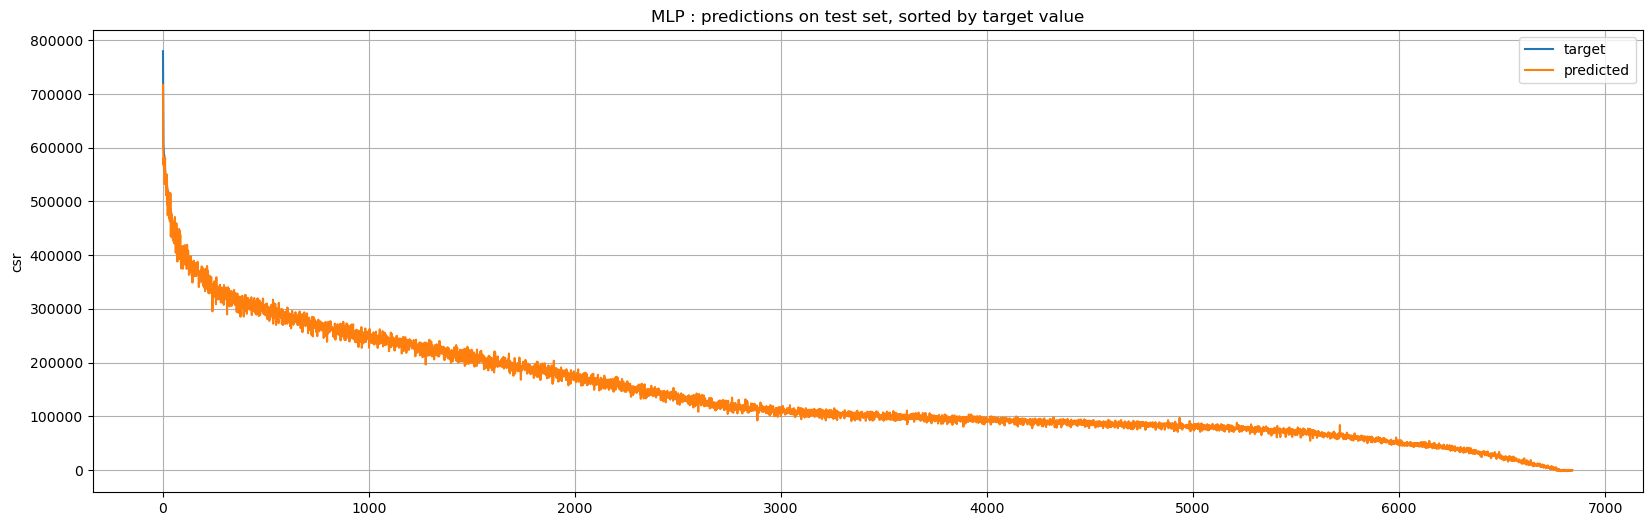

In [22]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(df_test['reel'].to_numpy(), label='target')
ax.plot(df_test['model'].to_numpy(), label='predicted')
ax.grid(True)
ax.set_ylabel('csr')
ax.set_title('MLP : predictions on test set, sorted by target value')
ax.legend()
plt.show()

## Gaussian Process Regression

In [23]:
# data is X_train, y_train and X_test, y_test
N = 20000  # limited by gpu capacity.

X_train_t = torch.tensor(X_train[:N].values, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test[:N].values, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train[:N].values, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test[:N].values, dtype=torch.float32).to(device)

In [24]:
# Gaussian Process Regressor Model

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        
        """An __init__ method that takes the training data and a likelihood, 
        and constructs whatever objects are necessary for the model"s forward method. 
        This will most commonly include things like a mean module and a kernel module.
        """
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # constant mean as prior mean
        self.mean_module = gpytorch.means.ConstantMean()
        # RBF kernel as prior covariance
        # NB : in GPyTorch, the white noise is handled by the likelihood, not the kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        """A forward method that takes in some n x d data x and returns a MultivariateNormal with the prior mean and covariance evaluated at x. 
        In other words, we return the vector mu(x) and the n x n matrix representing the prior mean and covariance matrix of the GP.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [25]:
# initialize likelihood
# The simplest likelihood for regression is the gpytorch.likelihoods.GaussianLikelihood. 
# This assumes a homoskedastic noise model (i.e. all inputs have the same observational noise).
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.NormalPrior(1e+4, 1e+5), learn_additional_noise=True)

In [26]:
# Initialize the model
model = ExactGPModel(X_train_t, y_train_t, likelihood).to(device)

In [27]:
# Train model on GPU if available

if torch.cuda.is_available():
    print(f"Going to GPU")
    model = model.cuda()
    likelihood = likelihood.cuda()
    X_train_t = X_train_t.cuda()
    y_train_t = y_train_t.cuda()
    X_test_t = X_test_t.cuda()
    y_test_t = y_test_t.cuda()

Going to GPU


In [28]:
# n epochs
training_iter = 0
iter_max = 300  # maximum number of iterations for training

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# error threshold
error_threshold = 1e-8
previous_loss = np.inf
error = np.inf

# training loop
t1 = timeit.default_timer()
print("Training GP model with GP Torch...")

# while error > error_threshold and training_iter <= iter_max:
while training_iter <= iter_max:
# for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train_t)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train_t)
    loss.backward()
    optimizer.step()
    # check error
    if training_iter >= 1:
        error = np.abs(previous_loss - loss.item())/ previous_loss
    previous_loss = loss.item()
    # report out
    if training_iter % 10 == 0:
        print(f"Iteration [{training_iter+1:<6} .../... {iter_max:<6}], Loss: {loss.item():.3e}, Error decrease on last iteration: {error*100:.2e}%, lengthscale : {model.covar_module.base_kernel.lengthscale.item():.2e}, noise (variance): {model.likelihood.noise.item():.2e}")
    # next iteration
    training_iter += 1
    
t2 = timeit.default_timer()
print("Training time: {:.2f} seconds".format(t2 - t1))

Training GP model with GP Torch...
Iteration [1      .../... 300   ], Loss: 1.036e+10, Error decrease on last iteration: inf%, lengthscale : 7.44e-01, noise (variance): 7.44e-01
Iteration [11     .../... 300   ], Loss: 5.592e+09, Error decrease on last iteration: 5.01e+00%, lengthscale : 1.31e+00, noise (variance): 1.35e+00
Iteration [21     .../... 300   ], Loss: 3.666e+09, Error decrease on last iteration: 3.88e+00%, lengthscale : 2.05e+00, noise (variance): 1.97e+00
Iteration [31     .../... 300   ], Loss: 1.909e+09, Error decrease on last iteration: 9.16e+00%, lengthscale : 3.11e+00, noise (variance): 2.46e+00
Iteration [41     .../... 300   ], Loss: 6.747e+08, Error decrease on last iteration: 8.88e+00%, lengthscale : 4.32e+00, noise (variance): 2.76e+00
Iteration [51     .../... 300   ], Loss: 3.415e+08, Error decrease on last iteration: 4.88e+00%, lengthscale : 5.22e+00, noise (variance): 2.91e+00
Iteration [61     .../... 300   ], Loss: 2.386e+08, Error decrease on last iterati

Plot model fit

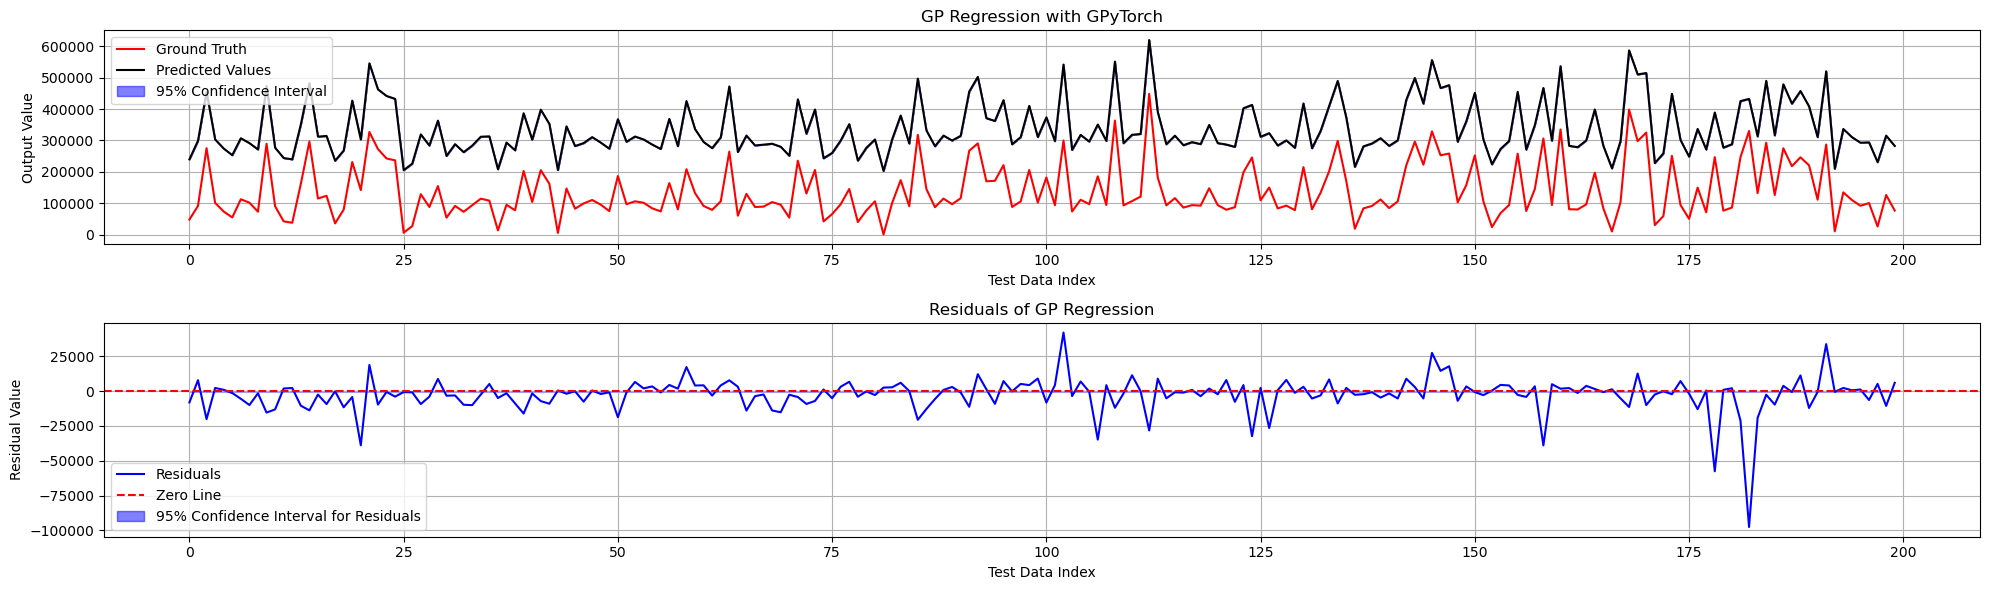

In [29]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Number of test points
N = 200
OFFSET = 200000

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test_t[:N]))  # returns a MultivariateNormal object, not a tensor !

# Plotting the results
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(20, 6))
    
    # plot ground truth
    ax[0].plot(y_test_t[:N].cpu().numpy(), 'r', label='Ground Truth')
    # plot observed values with credible interval
    ax[0].plot(observed_pred.mean.cpu().numpy()+OFFSET, 'k', label='Predicted Values')
    ax[0].fill_between(
        np.arange(N),
        observed_pred.mean.cpu().numpy() + OFFSET - 1.96 * observed_pred.stddev.cpu().numpy(),
        observed_pred.mean.cpu().numpy() + OFFSET + 1.96 * observed_pred.stddev.cpu().numpy(),
        alpha=0.5,
        color='blue',
        label='95% Confidence Interval'
    )
    # Set title and labels
    ax[0].set_title('GP Regression with GPyTorch')
    ax[0].set_xlabel('Test Data Index')
    ax[0].set_ylabel('Output Value')

    ax[0].legend()
    ax[0].grid()
    
    # lot the residuals
    residuals = observed_pred.mean.cpu().numpy() - y_test_t[:N].cpu().numpy()
    ax[1].plot(residuals, 'b', label='Residuals')
    ax[1].axhline(0, color='red', linestyle='--', label='Zero Line')
    ax[1].set_title('Residuals of GP Regression')
    ax[1].set_xlabel('Test Data Index')
    ax[1].set_ylabel('Residual Value')
    
    ax[1].fill_between(
        np.arange(N),
        0 - 1.96 * observed_pred.stddev.cpu().numpy(),
        0 + 1.96 * observed_pred.stddev.cpu().numpy(),
        alpha=0.5,
        color='blue',
        label='95% Confidence Interval for Residuals'
    )
    
    ax[1].legend()
    ax[1].grid()
    
    plt.tight_layout()
    plt.show()

In [30]:
# get metrics
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    full_preds = likelihood(model(X_test_t))

print(f'MAE = {mean_absolute_error(y_test_t.cpu(), full_preds.mean.cpu()):.0f}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_test_t.cpu(), full_preds.mean.cpu())):.0f}')

MAE = 8183
RMSE = 17268


In [31]:
df_test = pd.DataFrame(
    {
        'reel' : list(y_test),
        'model' : list(full_preds.mean.cpu().numpy())  # use mean of the predictive distribution
    }
)
df_test.sort_values(by=['reel'], ascending=False, inplace=True)

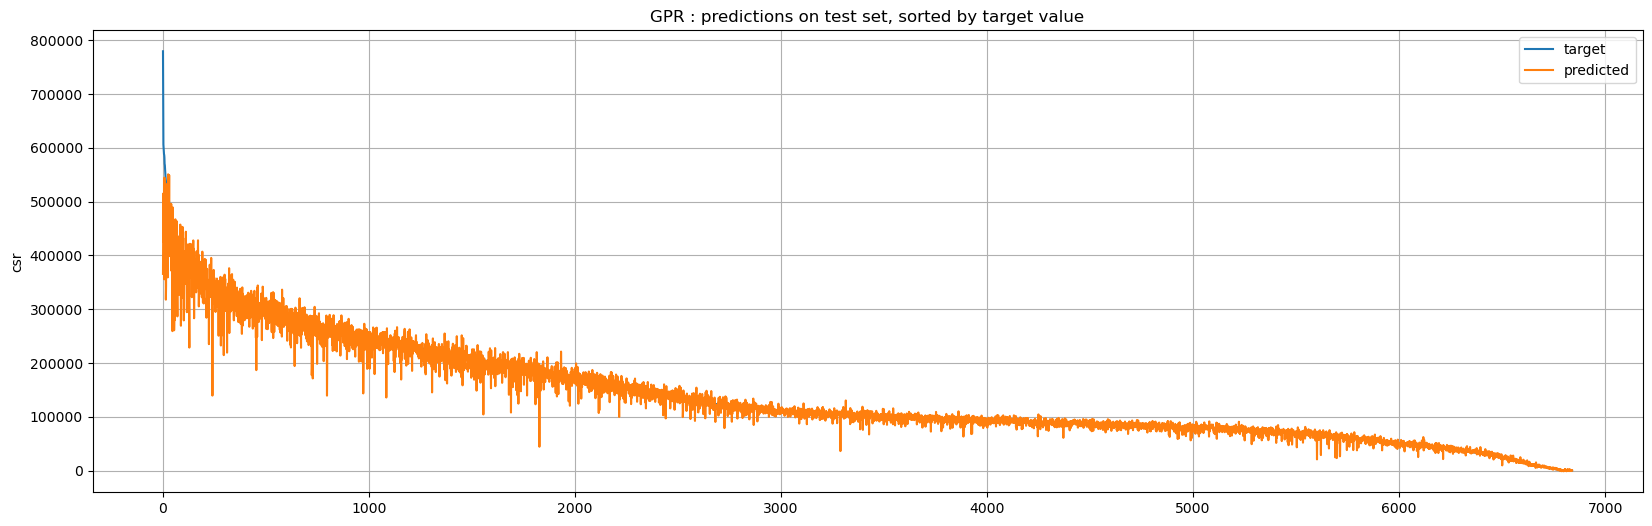

In [32]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(df_test['reel'].to_numpy(), label='target')
ax.plot(df_test['model'].to_numpy(), label='predicted')
ax.grid(True)
ax.set_ylabel('csr')
ax.set_title('GPR : predictions on test set, sorted by target value')
ax.legend()
plt.show()

# Conclusions

- The simple **Multi Layer Perceptron** is well suited to the regression task, and provides point estimates with good precisions (RMSE, MAE metrics). However, it does not provide credible intervals.
- The **Gaussian Process regressor** takes longer to train, as it naively scales in $O(n^3)$, and seems to have a lower precision. However, it can provide credible intervals.